In [1]:
import torch 
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from lxml import etree 
import glob
import torchvision
from PIL import Image
from torchvision import transforms 
import os 
from torch.utils import data
import numpy as np 
import torch.nn as nn 

In [2]:
demoimg = Image.open('Oxford-IIIT Pets Dataset/dataset/images/Abyssinian_1.jpg')

(-0.5, 599.5, 399.5, -0.5)

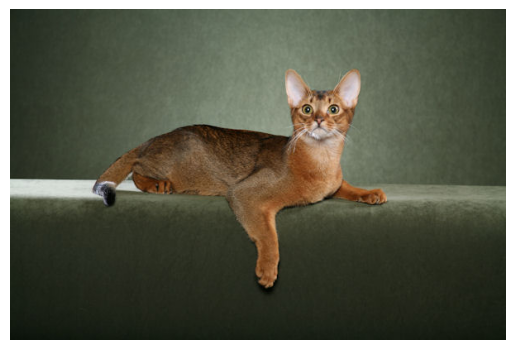

In [3]:
plt.imshow(demoimg)
plt.axis("off")

In [4]:
np_img = np.array(demoimg)

In [5]:
np_img.shape

(400, 600, 3)

In [6]:
demo_xml = open('Oxford-IIIT Pets Dataset/dataset/annotations/xmls/Abyssinian_1.xml').read()

In [7]:
demo_xml

'<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>\n'

In [7]:
tree = etree.HTML(demo_xml)

In [8]:
name = tree.xpath('//object/name/text()')
name

['cat']

In [9]:
width = int(tree.xpath('//size/width/text()')[0]) 
# width
height = int(tree.xpath('//size/height/text()')[0])
# height
xmin = int(tree.xpath('//bndbox/xmin/text()')[0])
xmax = int(tree.xpath('//bndbox/xmax/text()')[0])
ymin = int(tree.xpath('//bndbox/ymin/text()')[0])
ymax = int(tree.xpath('//bndbox/ymax/text()')[0])
xmin,xmax,ymin,ymax

(333, 425, 72, 158)

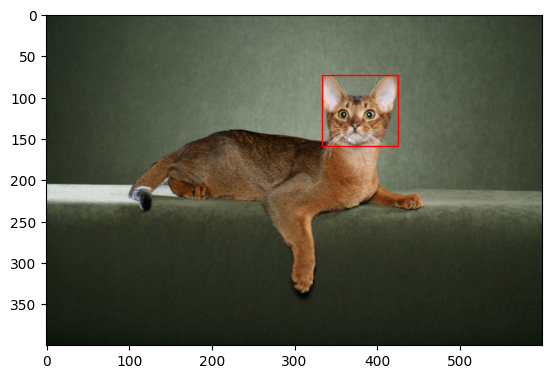

In [10]:
plt.imshow(demoimg)
rec = Rectangle((xmin,ymin),width=xmax-xmin,height=ymax-ymin,fill=False,color='red')
ax=plt.gca()
ax.axes.add_patch(rec)

In [11]:
resized_img = demoimg.resize((224,224)) 
xmin = int(xmin/width*224)
xmax = int(xmax/width*224)
ymin = int(ymin/height*224)
ymax = int(ymax/height*224) 

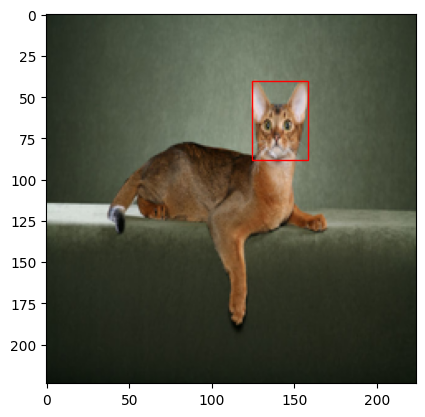

In [12]:
plt.imshow(resized_img) 
rec_resized = Rectangle((xmin,ymin),
                        width=xmax-xmin,
                        height=ymax-ymin,
                        fill=False,
                        color='red')
ax = plt.gca() 
ax.axes.add_patch(rec_resized)

## 创建输入   

### 获取所有图片路径 

In [13]:
imgs = glob.glob('Oxford-IIIT Pets Dataset/dataset/images/*.jpg')
imgs[:5]

['Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_1.jpg',
 'Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_10.jpg',
 'Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_100.jpg',
 'Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_101.jpg',
 'Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_102.jpg']

In [14]:
len(imgs)

7390

### 获取所有标签路径 

In [15]:
annos = glob.glob('Oxford-IIIT Pets Dataset/dataset/annotations/xmls/*.xml')
annos[:5]

['Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_1.xml',
 'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_10.xml',
 'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_100.xml',
 'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_101.xml',
 'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_102.xml']

In [16]:
len(annos)

3686

长度不对应,所以没有对所有文件进行标注  


那我们就只要标注过的

In [17]:
name_annoed = [ name.split('\\')[-1].split('.')[0] for name in annos]

In [18]:
name_annoed[:5]

['Abyssinian_1',
 'Abyssinian_10',
 'Abyssinian_100',
 'Abyssinian_101',
 'Abyssinian_102']

In [19]:
len(name_annoed)

3686

In [20]:
imgs_annoed = [] 
for img in imgs: 
    if img.split('\\')[-1].split('.')[0] in name_annoed:
        imgs_annoed.append(img)

In [21]:
imgs_annoed[:5]

['Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_1.jpg',
 'Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_10.jpg',
 'Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_100.jpg',
 'Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_101.jpg',
 'Oxford-IIIT Pets Dataset/dataset/images\\Abyssinian_102.jpg']

In [22]:
len(imgs_annoed)

3686

In [23]:
annos[:5]

['Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_1.xml',
 'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_10.xml',
 'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_100.xml',
 'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_101.xml',
 'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_102.xml']

可以发现是一一对应的

### 解析xml  

现在的任务是获取所有xml文件的xmin...等的与宽高的比值

In [24]:
annos[1] 

'Oxford-IIIT Pets Dataset/dataset/annotations/xmls\\Abyssinian_10.xml'

In [25]:
demot = etree.HTML(annos[0])

In [26]:
demo_width = int(tree.xpath('//size/width/text()')[0]) 

In [27]:
demo_width

600

定义一个函数用来获取xml的值

In [28]:
def tolabel(xmlfile): 
    xmlfile = open(r'{}'.format(xmlfile)).read()
    tree=etree.HTML(xmlfile) 
    width = int(tree.xpath('//size/width/text()')[0]) 
    height = int(tree.xpath('//size/height/text()')[0])
    
    xmin = int(tree.xpath('//bndbox/xmin/text()')[0])
    xmax = int(tree.xpath('//bndbox/xmax/text()')[0])
    ymin = int(tree.xpath('//bndbox/ymin/text()')[0])
    ymax = int(tree.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width,xmax/width,ymin/height,ymax/height]

In [29]:
labels =[tolabel(xml_file) for xml_file in annos]                                                                                                                                                           

In [30]:
labels[1]

[0.192, 0.768, 0.21, 0.582]

### 创建dataset

In [31]:
len(annos)

3686

In [32]:
index = np.random.permutation(len(labels))

In [33]:
data_path = np.array(imgs_annoed)[index]
labels = np.array(labels)[index]

In [34]:
labels.shape

(3686, 4)

In [35]:
labels = labels.astype(np.float32)

In [36]:
i = int(len(labels)*0.8)

In [37]:
train_imgs = data_path[:i]
train_labels = labels[:i]

test_imgs = data_path[i:]
test_labels = labels[i:]

In [38]:
transform = transforms.Compose(
    [
        transforms.Resize((224,224)), 
        transforms.ToTensor()
    ]
)

In [39]:
class OXfordDataset(torch.utils.data.Dataset): 
    def __init__(self,imgpath,imglabel,transform):
        self.imgpath = imgpath
        self.imglabel = imglabel
        self.transform = transform
    def __len__(self): 
        return len(self.imgpath)
    def __getitem__(self,index):  
        img = self.imgpath[index]

        pil_img = Image.open(img).convert('RGB')

        if self.transform: 
            pil_img = transform(pil_img) 
        #由于返回的label是一个长度为4的列表,所以我们可以直接用四个值接收 
        l1,l2,l3,l4 = self.imglabel[index] #直接解包赋值
        #注意,四个标签分别对应于xmin,xmax,ymin,ymax
        return pil_img,l1,l2,l3,l4 

In [40]:
train_ds = OXfordDataset(imgpath=train_imgs,imglabel=train_labels,transform=transform)

In [41]:
test_ds = OXfordDataset(imgpath=test_imgs,imglabel=test_labels,transform=transform)

In [42]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=32)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=64)

In [43]:
demo_batch,demol1,demol2,demol3,demol4 = next(iter(train_dl))

In [44]:
demo_batch.shape

torch.Size([32, 3, 224, 224])

In [45]:
demol1.shape

torch.Size([32])

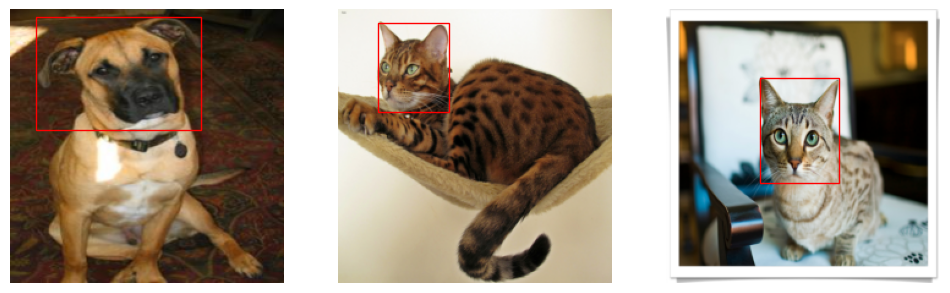

In [46]:
plt.figure(figsize=(12,8))

for idx,(img,xmin,xmax,ymin,ymax) in enumerate(zip(demo_batch[:3],demol1,demol2,demol3,demol4)): 
    img = img.permute(1,2,0).numpy()
    plt.subplot(1,3,idx+1)
    plt.imshow(img)
    plt.axis('off') 
    axs = plt.gca()
    xmin,xmax,ymin,ymax = xmin*224,xmax*224,ymin*224,ymax*224
    rec_resized = Rectangle((xmin,ymin),
                        width=xmax-xmin,
                        height=ymax-ymin,
                        fill=False,
                        color='red')
    ax = plt.gca() 
    ax.axes.add_patch(rec_resized)

### 创建定位模型

#### 使用卷积基提取特征 

In [47]:
resnet = torchvision.models.resnet101(weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1)

In [48]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [50]:
len(list(resnet.children()))

10

In [51]:
list(resnet.children())[-1] 

Linear(in_features=2048, out_features=1000, bias=True)

我们要的是除去最后一层的其它所有层

利用非最后一层的所有层来创建一个卷积基

In [52]:
conv_base = nn.Sequential(*list(resnet.children())[:-1])

In [53]:
conv_base

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [54]:
class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        #卷积部分直接使用预训练的卷积基
        self.convbase = nn.Sequential(*list(resnet.children())[:-1])
        #因为最后要返回的是四个坐标值,所以采用4个全连接层
        self.fc1 = nn.Linear(in_features=resnet.fc.in_features,out_features=1)
        self.fc2 = nn.Linear(in_features=resnet.fc.in_features,out_features=1)
        self.fc3 = nn.Linear(in_features=resnet.fc.in_features,out_features=1)
        self.fc4 = nn.Linear(in_features=resnet.fc.in_features,out_features=1)

    def forward(self,x):
        x = self.convbase(x) #先进行卷积部分  
        #然后进入全连接部分  
        x = torch.flatten(x, start_dim=1) # 从第1维开始展平（跳过batch维度）
        x1 = self.fc1(x).squeeze(1)
        x2 = self.fc2(x).squeeze(1)
        x3 = self.fc3(x).squeeze(1)
        x4 = self.fc4(x).squeeze(1)
        return x1,x2,x3,x4  #最后返回预测值 
        
        

### 训练

In [55]:
mynet = Net() 

In [56]:
optimizer = torch.optim.Adam(mynet.parameters(),lr=0.001)
loss_fn  = nn.MSELoss() #因为预测的是坐标,是一个连续值,属于回归问题,故用均方差损失函数

In [57]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    # correct = 0
    total = 0
    running_loss = 0
    # tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
  
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y1,y2,y3,y4 in Train_DL:
        #注意这里有变化
        x,y1,y2,y3,y4 =(
            x.to(device), 
            y1.to(device),
            y2.to(device),
            y3.to(device), 
            y4.to(device),
        )
        y_pred1,y_pred2,y_pred3,y_pred4 = Model_m(x)
        loss1 = loss_fn(y_pred1, y1)
        loss2 = loss_fn(y_pred2,y2)  
        loss3 = loss_fn(y_pred3,y3)  
        loss4 = loss_fn(y_pred4,y4)  
        loss = loss1+loss2+loss3+loss4
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            running_loss += loss.item()
    epoch_loss = running_loss/len(Train_DL)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for  x, y1,y2,y3,y4  in TST_DL:
            x,y1,y2,y3,y4 =(
                x.to(device), 
                y1.to(device),
                y2.to(device),
                y3.to(device), 
                y4.to(device),
            )
            y_pred1,y_pred2,y_pred3,y_pred4 = Model_m(x)
            loss1 = loss_fn(y_pred1, y1)
            loss2 = loss_fn(y_pred2,y2)  
            loss3 = loss_fn(y_pred3,y3)  
            loss4 = loss_fn(y_pred4,y4)  
            loss = loss1+loss2+loss3+loss4
            tstrunning_loss += loss.item()
    tstepoch_loss = tstrunning_loss/len(TST_DL)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | tstloss:{tstepoch_loss:.3f}'
    )

    return epoch_loss,tstepoch_loss


In [58]:
from torch.optim.lr_scheduler import StepLR
# import copy
# best_state = copy.deepcopy(model.state_dict()) 
# best_acc = 0 
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
train_loss_gpu = []
# train_acc_gpu = []
tst_loss_gpu = []
# tst_acc_gpu = []
epochs = 6

for epoch in range(epochs):
      # 每个 epoch 都训练
    epoch_loss, tstepoch_loss = fit_gpu(
        Train_DL=train_dl,
        TST_DL=test_dl,
        Model_m=mynet,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    # if tstepoch_acc > best_acc: 
    #     best_state = copy.deepcopy(model.state_dict())
    #     best_acc = epoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    # train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    # tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    # current_lr = optimizer.param_groups[0]['lr']
    # print(f"Epoch {epoch}: 学习率已更新为 {current_lr:.2e}")

epoch:0 | loss:0.006 | tstloss:0.001
epoch:1 | loss:0.002 | tstloss:0.001
epoch:2 | loss:0.001 | tstloss:0.001
epoch:3 | loss:0.001 | tstloss:0.000
epoch:4 | loss:0.001 | tstloss:0.001
epoch:5 | loss:0.000 | tstloss:0.000


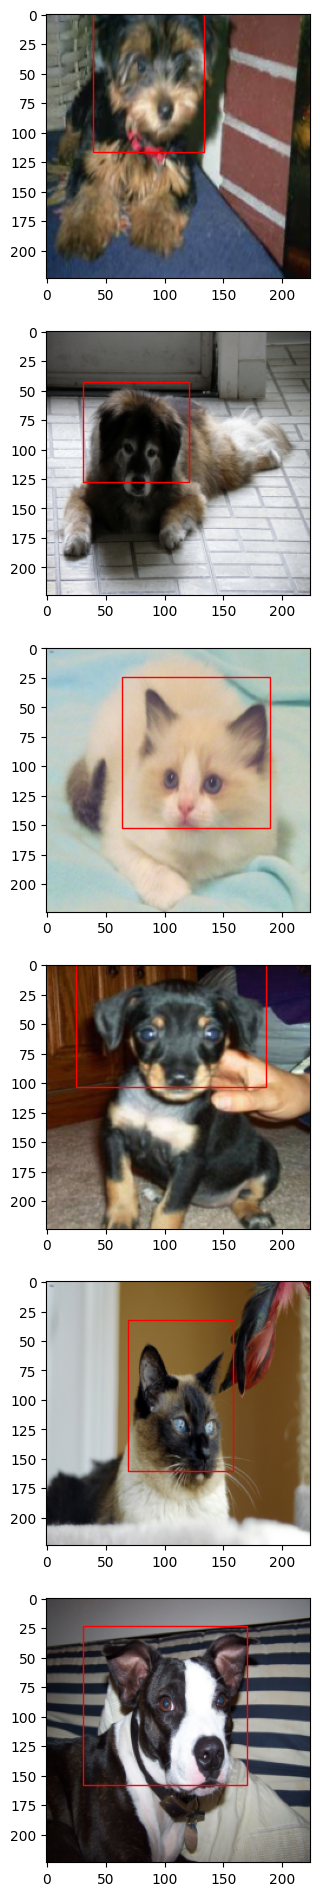

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.figure(figsize=(8,24)) 
imgs,_,_,_,_ = next(iter(test_dl)) 
imgs = imgs.to(device)  
out1,out2,out3,out4 = mynet(imgs)  
for i in range(6):  
    plt.subplot(6,1,i+1)  
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy()) 
    xmin,xmax,ymin,ymax = (out1[i].item()*224, 
                          out2[i].item()*224, 
                          out3[i].item()*224, 
                          out4[i].item()*224)  
    rect = Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,fill=False,color='red')
    ax = plt.gca()  
    ax.axes.add_patch(rect)

这段代码的核心功能是**可视化模型在测试集上的预测结果**，通过绘制图像和模型预测的边界框（红色框），直观地观察模型对宠物目标的定位效果。下面逐部分解读，重点说明 `out1[i]` 这类表达式的含义：


### **整体流程概述**
1. 从测试数据加载器中获取一批图像。
2. 将图像输入训练好的模型，得到边界框坐标的预测结果。
3. 循环绘制前6张图像，并在每张图像上叠加模型预测的红色边界框。


### **逐行代码解读**

#### 1. 设备设置与图像准备
```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```
- 定义计算设备（GPU优先，若无则用CPU），确保数据和模型在同一设备上。

```python
plt.figure(figsize=(8,24))  # 创建画布，宽8英寸，高24英寸（适合纵向排列6张图）
imgs,_,_,_,_ = next(iter(test_dl))  # 从测试数据加载器中取一个批次的图像和标签（标签用_忽略）
imgs = imgs.to(device)  # 将图像移动到指定设备（与模型一致）
```


#### 2. 模型预测
```python
out1,out2,out3,out4 = mynet(imgs)  # 输入图像到模型，得到4个输出（分别对应xmin, xmax, ymin, ymax的预测值）
```
- `mynet` 是训练好的目标定位模型，输入图像后输出4个张量，分别对应边界框的4个坐标（归一化值，范围0~1）：
  - `out1`：所有图像的 `xmin`（左上角x坐标）预测值 是一个列表[xmin0,xmin1,xmin2......]下面的也可以这样理解  
  - `out2`：所有图像的 `xmax`（右下角x坐标）预测值
  - `out3`：所有图像的 `ymin`（左上角y坐标）预测值
  - `out4`：所有图像的 `ymax`（右下角y坐标）预测值


#### 3. 循环绘制图像与边界框
```python
for i in range(6):  # 循环绘制前6张图像
    plt.subplot(6,1,i+1)  # 创建6行1列的子图，当前绘制第i+1个位置
    # 显示图像：
    # imgs[i]：取批次中第i张图像
    # permute(1,2,0)：将图像的通道顺序从[C,H,W]（PyTorch格式）转为[H,W,C]（Matplotlib显示格式）
    # cpu().numpy()：将图像从GPU（若使用）移回CPU，并转为numpy数组（Matplotlib仅支持numpy格式）
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
    
    # 计算边界框坐标（将归一化值转回像素坐标）：
    # out1[i].item()：取第i张图像的xmin预测值（从张量中提取单个数值）
    # *224：因为图像被Resize为224x224，所以乘以224还原为像素坐标
    xmin = out1[i].item() * 224  
    xmax = out2[i].item() * 224  
    ymin = out3[i].item() * 224  
    ymax = out4[i].item() * 224  
    
    # 绘制红色边界框：
    # Rectangle参数：(xmin, ymin)为左上角坐标；xmax-xmin为宽度；ymax-ymin为高度
    rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='red')
    ax = plt.gca()  # 获取当前子图的坐标轴
    ax.axes.add_patch(rect)  # 将边界框添加到图像上
```


### **关键：`out1[i]` 的含义**
- `out1` 是模型输出的第一个张量，形状为 `(batch_size,)`（假设经过 `squeeze()` 处理后），存储了**整个批次中所有图像的 `xmin` 预测值**（`xmin` 是边界框左上角的x坐标）。
- `out1[i]` 表示取批次中**第i张图像**的 `xmin` 预测值（是一个张量，形状为 `()`，即标量张量）。
- 后续的 `.item()` 是将标量张量转换为Python原生数值（如float），方便计算和绘图。

同理：
- `out2[i]`：第i张图像的 `xmax` 预测值
- `out3[i]`：第i张图像的 `ymin` 预测值
- `out4[i]`：第i张图像的 `ymax` 预测值


### **总结**
这段代码通过循环遍历批次中的前6张图像，将模型预测的边界框坐标（`out1` 到 `out4`）转换为像素坐标后，绘制在原图上，直观展示模型的定位效果。`out1[i]` 这类表达式的作用是**提取第i张图像的对应边界框坐标预测值**，是连接模型输出与可视化的关键步骤。

是的，`out1,out2,out3,out4 = mynet(imgs)` **一次性获取了整个批次的输出**，不需要显式循环。这是因为PyTorch模型支持**批量处理**（Batch Processing），即一次可以处理多张图像，而不是一张一张地处理。


### **详细解释**
#### 1. **批量处理机制**
PyTorch模型设计为支持批量输入，当你传入一个批次的图像（形状通常为 `[batch_size, 3, 224, 224]`）时，模型会并行处理所有图像，并一次性输出整个批次的结果。

例如，假设 `test_dl` 的 `batch_size=64`，则 `imgs` 的形状为 `[64, 3, 224, 224]`。当你调用 `mynet(imgs)` 时：
- 模型会同时处理这64张图像。
- 输出的 `out1, out2, out3, out4` 分别是64张图像的 `xmin, xmax, ymin, ymax` 预测值，每个张量的形状为 `[64]`（假设经过 `squeeze()` 处理后）。


#### 2. **为什么不需要循环？**
在深度学习中，为了提高计算效率，通常会**向量化操作**（即使用矩阵/张量运算），而不是通过Python循环逐个处理样本。PyTorch的底层使用高效的CUDA（GPU）或CPU并行计算库，批量处理的速度远快于循环处理。

例如，如果你手动用循环处理64张图像：
```python
# 不推荐的低效方式（仅用于对比说明）
out1_list, out2_list, out3_list, out4_list = [], [], [], []
for img in imgs:  # 循环64次，每次处理1张图像
    o1, o2, o3, o4 = mynet(img.unsqueeze(0))  # 注意：单张图像需要添加batch维度
    out1_list.append(o1)
    out2_list.append(o2)
    out3_list.append(o3)
    out4_list.append(o4)
# 再将结果拼接成张量
out1 = torch.cat(out1_list)
out2 = torch.cat(out2_list)
out3 = torch.cat(out3_list)
out4 = torch.cat(out4_list)
```
这种方式会比直接批量处理慢得多，因为：
- 每次循环都有函数调用开销。
- 无法充分利用GPU的并行计算能力。


#### 3. **代码中的循环作用**
虽然模型输出是批量的，但后续的**可视化步骤**需要逐个处理图像并绘制边界框，因此需要一个循环：
```python
for i in range(6):  # 循环6次，处理前6张图像
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())  # 显示第i张图像
    xmin = out1[i].item() * 224  # 获取第i张图像的xmin预测值并转为像素坐标
    # ... 绘制边界框
```
这个循环**不是用于模型推理**，而是用于**结果展示**：从批量输出中提取单张图像的预测结果，并绘制到图上。


### **总结**
- **模型推理阶段**：通过 `mynet(imgs)` 一次性处理整个批次，输出所有图像的预测结果，无需循环。
- **后处理阶段**：如需对单张图像进行操作（如可视化），则需要通过索引（如 `out1[i]`）提取单张图像的结果。

这种设计使得代码既高效又简洁。

In [62]:

# 1. 确保模型处于 eval 模式（推理模式）
mynet.eval()

# 2. 创建一个示例输入（与模型输入形状一致，用于跟踪模型计算过程）
# 假设输入图像形状为 [batch_size, 3, 224, 224]，这里用 batch_size=1 作为示例
example_input = torch.randn(1, 3, 224, 224).to(device)  # 随机生成一个符合输入格式的张量

# 3. 用 torch.jit.trace 转换模型为 TorchScript 格式
# 跟踪模型对示例输入的计算过程，生成脚本化模型
traced_script_module = torch.jit.trace(mynet, example_input)

# 4. 保存脚本化模型（后缀通常为 .pt 或 .pth）
save_path = "model/pet_detection_model.pt"  # 保存路径
traced_script_module.save(save_path)

print(f"模型已保存为 TorchScript 格式：{save_path}")

模型已保存为 TorchScript 格式：model/pet_detection_model.pt


In [63]:

# 1. 确保模型处于 eval 模式（关闭dropout、BatchNorm等训练相关层）
mynet.eval()

# 2. 定义输入形状（与模型实际输入一致）
# 输入格式：[batch_size, 通道数, 高, 宽]，这里用batch_size=1作为示例
batch_size = 1
input_shape = (batch_size, 3, 224, 224)  # 3通道，224x224图像

# 3. 创建示例输入张量（需与模型在同一设备）
example_input = torch.randn(*input_shape).to(device)

# 4. 导出为ONNX格式
onnx_save_path = "model/pet_detection_model.onnx"  # 保存路径

# 调用torch.onnx.export导出
torch.onnx.export(
    model=mynet,  # 要导出的模型
    args=example_input,  # 示例输入（用于跟踪计算图）
    f=onnx_save_path,  # 保存路径
    input_names=["input_image"],  # 输入节点名（可选，方便部署时识别）
    output_names=["xmin", "xmax", "ymin", "ymax"],  # 输出节点名（对应边界框的四个坐标）
    dynamic_axes={  # 声明动态维度（batch_size可动态变化）
        "input_image": {0: "batch_size"},  # 输入的第0维（batch_size）是动态的
        "xmin": {0: "batch_size"},
        "xmax": {0: "batch_size"},
        "ymin": {0: "batch_size"},
        "ymax": {0: "batch_size"}
    },
    opset_version=12  # ONNX算子集版本（建议用11+，兼容性更好）
)

print(f"模型已导出为ONNX格式：{onnx_save_path}")

模型已导出为ONNX格式：model/pet_detection_model.onnx
